In [59]:
from custom_tf_idf_transformer_class import CustomClassTfidfTransformer
from write_csv_and_push_data import cleaning_strings

import numpy as np
import pandas as pd
from annoy import AnnoyIndex
from cdiscount import config, snowflake
from cdiscount.config import load_secrets
from snowflake.connector import SnowflakeConnection
from tqdm import tqdm
import nltk
from collections import Counter
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

GET EMBEDDINGS

In [2]:
secrets_file = "/home/jupyter/icarusight/neo4j/secrets.yml"
SNOW_SECRETS = load_secrets(filename=secrets_file, key="snowflake")
AZURE_SECRETS = load_secrets(filename=secrets_file, key="azure_openai_embeddings")

In [3]:
secrets = config.load_secrets("secrets.yml", key="snowflake")
embedding_query = "queries/get_embeddings.sql"

with snowflake.get_snowflake_connection(**secrets) as con:
    embeddings_df = snowflake.query_snowflake_to_df(embedding_query, con=con)
print("first bottleneck passed (querying bottleneck)")
embeddings_df["embedding"] = embeddings_df.embedding.apply(eval)
print("second bottleneck passed (evaluating bottleneck)")
np.all(~embeddings_df.embedding.apply(lambda x: np.all(x == 0.0)))

first bottleneck passed (querying bottleneck)
second bottleneck passed (evaluating bottleneck)


True

ANNOY(ING) NEIGHBORS

In [4]:
def id2product_id(index):
    return embeddings_df.product_id.iloc[index]

def get_neighbors(u, i, k):
    neighbors, distances = u.get_nns_by_item(i=i, n=k + 1, include_distances=True)
    return pd.DataFrame(
        {
            "id": i,
            "rank": [j for j in range(1, k + 1)], #Removing the item itself
            "neighbor_id": neighbors[1 : k + 1],
            "distance": distances[1 : k + 1],
        }
    )

In [30]:
build_tree = False # When set to True, this creates the canape_embeddings.ann file 
min_max_normalization = True
saving_csv = True

if build_tree:
    t = AnnoyIndex(AZURE_SECRETS["expected_embedding_size"], "dot")
    for i, v in enumerate(embeddings_df.embedding):
        t.add_item(i, v)
    t.build(n_trees=100, n_jobs=-1)
    vdb_file = "canape_embeddings.ann"
    t.save(vdb_file)


u = AnnoyIndex(AZURE_SECRETS['expected_embedding_size'], 'dot')
u.load(vdb_file)
all_neighbors = []
for i in tqdm(range(0, u.get_n_items())):
    all_neighbors.append(get_neighbors(u=u, i=i, k=10))
all_neighbors = pd.concat(all_neighbors)
all_neighbors['id'] = all_neighbors['id'].apply(id2product_id)
all_neighbors['neighbor_id'] = all_neighbors['neighbor_id'].apply(id2product_id)
if min_max_normalization:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    all_neighbors['distance'] = scaler.fit_transform(all_neighbors[['distance']])
if saving_csv:
    all_neighbors.to_csv("csv_files/product_product.csv", index=False, sep='\u0001')

100%|██████████| 32340/32340 [00:37<00:00, 854.56it/s]


In [ ]:
print(all_neighbors.where(all_neighbors['distance'] == 0).dropna())

                 id  rank       neighbor_id  distance
9  PAN1690215318571  10.0  BOB3701061707125       0.0


In [ ]:
print(all_neighbors['distance'].min(), "|", all_neighbors['distance'].max())

0.0 | 1.0000000000000004


In [ ]:
import write_csv_and_push_data as wcpd
from importlib import reload
reload(wcpd)

# wcpd.write_csv_from_snowflake() # Using 'queries' folder
# sshpass -p password ssh vincent.tardieux@a08datasc002
# !scp csv_files/products_properties.csv vincent.tardieux@a08datasc002:/data2/dsc/icarusight_neo4j/import/products_properties.csv
# !scp csv_files/products_sellers.csv vincent.tardieux@a08datasc002:/data2/dsc/icarusight_neo4j/import/products_sellers.csv
# !scp vincent.tardieux@a08datasc002:/home/CDBDX/vincent.tardieux/lr_communities_products.csv .


wcpd.push_data_to_neo4j(weighted_relationship=True) # Needs Neo4j's docker image running

Cleaning done
Indexes done
Product nodes added
Properties nodes added
Sellers nodes added
product_property relationships added
product_seller relationships added
product_product relationships added


ANALYSE DE COMMUNAUTES

In [60]:
#from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer

def extract_vocabulary(documents, stop_words, min_len: int = 3, min_df: int = 2):
    vocabulary = ' '.join(documents)
    vocabulary = [w for w in vocabulary.split() if w not in stop_words]
    vocabulary = Counter(vocabulary)
    for k, v in vocabulary.most_common():
        if v < min_df or len(k) < min_len:
            del vocabulary[k]
    return [k for k, _ in vocabulary.most_common()]

def merge_columns(row):
    return f"{' '.join(row['product_name_list'])} {row['description']}"

def get_top_words(response, threshold, feature_array):
    #response_normalized = normalize(response, axis=1, norm='l2')
    response_normalized = custom_norm(response.toarray())
    response_normalized = response_normalized.reshape(-1)
    sorted_nzs = np.argsort(response_normalized.data)[::-1]
    feature_array = feature_array[sorted_nzs]
    response_normalized = response_normalized[sorted_nzs]
    response_normalized = response_normalized > threshold
    res = feature_array[response_normalized]
    return np.apply_along_axis(' | '.join, 0, res)

def custom_norm(x):
    norm = x.sum(axis=1)
    return x / norm

# TF-IDF METHOD
def add_tf_idf_words(document_list, stopwords, threshold):
    vectorizer = CountVectorizer(vocabulary=extract_vocabulary(documents=document_list, stop_words=stopwords))
    vector = vectorizer.transform(document_list)
    v = CustomClassTfidfTransformer(use_idf=True)
    x = v.fit_transform(vector)
    features = np.array(vectorizer.get_feature_names_out())
    return [get_top_words(response=item, threshold=threshold, feature_array=features) for item in x]

# COUNT VECTORIZER METHOD
def add_count_vectorizer_words(document_list, stopwords, threshold):
    vectorizer = CountVectorizer(vocabulary=extract_vocabulary(documents=document_list, stop_words=stopwords))
    vector = vectorizer.transform(document_list)
    features = np.array(vectorizer.get_feature_names_out())
    return [get_top_words(response=item, threshold=threshold, feature_array=features) for item in vector]

In [200]:
# Creating communities_df

stop_words = ["sous", "sur", "en", "a", "d", "l", "de", "du", "des", "le", "la", "les", "un", "une", "mais", "ou", "et", "donc", "or", "ni", "car", "ce", "se", "ces", "ses", "ne", "pas", "tout", "tous", "toute", "toutes"]
stop_words += ["je", "tu", "il", "elle", "nous", "vous", "ils", "elles"]
stop_words += nltk.corpus.stopwords.words('french')

saving = True
creation = 0

if creation == 3:
    full_df = pd.read_csv("csv_files/communities_analysis/community_all_out.csv", sep=",", engine="python")
if creation == 2:
    full_df = pd.read_csv("csv_files/communities_analysis/weighted_communities_product_only.csv", sep=",", engine="python")
if creation == 1:
    full_df = pd.read_csv("csv_files/communities_analysis/louvain_communities_product_properties.csv", sep=",", engine="python")
if creation == 0:
    full_df = pd.read_csv("csv_files/communities_analysis/louvain_communities_product.csv", sep=",", engine="python")

full_df.description = cleaning_strings(full_df.description)
full_df.product_name = cleaning_strings(full_df.product_name)
communities_df = full_df.groupby('community_id')['description'].apply(lambda x: " | ".join(x)).reset_index()
communities_df.set_index("community_id", inplace=True)
count = full_df.groupby('community_id').product_id.count().reset_index()
count.set_index("community_id", inplace=True)
communities_df["community_size"] = count.product_id
len_before = len(communities_df)
communities_df.drop(communities_df[communities_df.community_size < 2].index, inplace=True)
len_after = len(communities_df)
print(f"len before is:{len_before} | len after is:{len_after}")
communities_df["product_id_list"] = full_df.groupby("community_id").product_id.apply(list)
communities_df["product_name_list"] = full_df.groupby("community_id").product_name.apply(list)

if creation != 1:
    communities_df["category_name_list"] = full_df.groupby("community_id").category_name.apply(list)
    communities_df['category_counts'] = communities_df['category_name_list'].apply(lambda x: dict(Counter(x)))

communities_df['document'] = communities_df.apply(merge_columns, axis=1)
communities_df['count_vectorizer_top_words'] = add_count_vectorizer_words(document_list=communities_df.document, stopwords=stop_words, threshold=0.025)
communities_df['tf_idf_top_words'] = add_tf_idf_words(document_list=communities_df.document, stopwords=stop_words, threshold=0.015)



communities_df = communities_df.sort_values("community_size", ascending=False)
if saving:
    if creation == 3:
        communities_df.to_csv('results/communities_analysis_all_out.csv')
    if creation == 2:
        communities_df.to_csv('results/weighted_communities_analysis_louvain_products_only.csv')
    if creation == 1:
        communities_df.to_csv('results/communities_analysis_louvain_with_properties.csv')
    if creation == 0:
        communities_df.to_csv('results/communities_analysis_louvain_products_only.csv')

len before is:141 | len after is:141


/home/jupyter/icarusight/neo4j/custom_tf_idf_transformer_class.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


In [206]:
# Get pair distances with assigned communities (product_id/communities/distances mapping)
# Get only product_id and community_id
products_communities_df = full_df.drop(['product_name', 'category_name', 'description'], axis=1)
communities_distances_df = pd.merge(distance_df, products_communities_df, on='product_id', how='inner')
products_communities_df.rename(columns={'product_id': 'neighbor_id', 'community_id': 'neighbor_community_id'}, inplace=True)
communities_distances_df = pd.merge(communities_distances_df, products_communities_df, on='neighbor_id', how='inner')
communities_distances_df.head(5)

,product_id,rank,neighbor_id,distance,community_id,neighbor_community_id
0,YES7605723704018,1,YES7605723704414,0.983247,2474,2474
1,YES7605723698119,10,YES7605723704414,0.978033,2474,2474
2,YES7605723698195,9,YES7605723704414,0.980467,2474,2474
3,YES7605723698393,4,YES7605723704414,0.978918,2474,2474
4,YES7605723698157,7,YES7605723704414,0.981616,2474,2474


In [396]:
infos = communities_distances_df[communities_distances_df.community_id == 
            communities_distances_df.neighbor_community_id].groupby('community_id').agg(
                dmean=("distance", "mean"),
                dmedian=("distance", lambda x: np.quantile(x,0.5)),
                quantile_025=("distance", lambda x: np.quantile(x,0.25)),
                quantile_095=("distance", lambda x: np.quantile(x,0.95)),
                quantile_005=("distance", lambda x: np.quantile(x,0.05))
            )

infos['community_size'] = communities_df['community_size']
infos.sort_values('community_size', ascending=True, inplace=True)
infos['len_edges'] = communities_distances_df.loc[communities_distances_df.community_id == communities_distances_df.neighbor_community_id].groupby('community_id').count().product_id
infos['density'] = (infos['len_edges']) / (infos['community_size'] * 10)

infos.sort_values('dmean', ascending=False, inplace=True)
print(len(infos))
display(infos)

125


,dmean,dmedian,quantile_025,quantile_095,quantile_005,community_size,len_edges,density
community_id,,,,,,,,
1129,0.994541,0.990456,0.990121,0.999882,0.989943,11,110,1.000000
17641,0.990175,0.994291,0.980812,0.996709,0.975981,32,320,1.000000
11806,0.987310,0.982375,0.980837,0.999789,0.979192,11,110,1.000000
2739,0.984716,0.986641,0.979308,0.999032,0.960039,41,410,1.000000
21125,0.983892,0.982624,0.976493,0.997600,0.967374,63,630,1.000000
...,...,...,...,...,...,...,...,...
33264,0.800329,0.784821,0.725521,0.962762,0.651488,215,1942,0.903256
3136,0.798732,0.749303,0.730074,0.984586,0.715031,94,77,0.081915
17853,0.792241,0.771925,0.708750,0.963504,0.642800,2307,17763,0.769961


<Axes: xlabel='dmean', ylabel='density'>

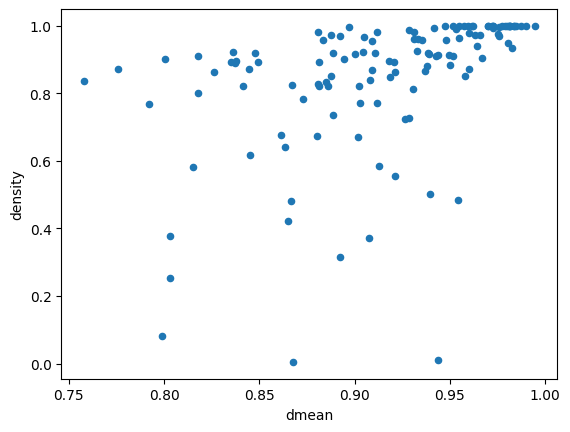

In [412]:
infos.plot.scatter(x='dmean', y='density')

In [409]:
def look4one_community(idx):
    row = communities_df.loc[idx]
    row_infos = infos.loc[idx] 
    print("\n\t------INFOS------")
    print(f"Mean: {row_infos.dmean} | Median: {row_infos.dmedian} | Density: {row_infos.density} | Community_size: {row.community_size}\n",
          f"| Quantile 25%: {row_infos.quantile_025} | Quantile 95%: {row_infos.quantile_095} | Quantile 5%: {row_infos.quantile_005}")
    print("\t------PRODUCTS_NAME_SAMPLE------")
    products_list = row.product_name_list[:25]
    for product in products_list:
        print(product)
    print("\t------CATEGORY_COUNTS------")
    print(row.category_counts, end="\n\n" + "-" * 150 + "\n")

In [404]:
look4one_community(3136)


	------INFOS------
Mean: 0.7987315218395985 | Median: 0.7493033802173934 | intra_density: 0.08191489361702127 | Community_size: 94
 | Quartile 25%: 0.7300742744857742 | Quartile 95%: 0.9845859095569033 | Quartile 5%: 0.7150307472597022
	------PRODUCTS_NAME_SAMPLE------
1 2 3 4 places housse canape fauteuil couvre sofa campagne doux meubles maison,serviette chaude anti glisse,rose,taie d orei h6094
housse canape, couverture canape d angle couleur unie differentes tailles ,housse canape chaude antiderapante,gris,70 210 h9227
housse canape 12 34 places salon couverture protecteur meuble maison,serviette chaude anti glisse canape,cafe profond,90 h9173
housse canape lit clic clac le recouvrement complet canapes accoudoirs, amovible, parfaite protection canape,housse canape a h9237
housse canape1 23 4places accoudoirs anti acariens,housse canape antiderapante,grise,90 240cm h6092
housse canape salon couverture canape 12 34 place,serviette chaude anti glisse,beige,70 240cm h9199
housses cana

In [410]:
print(infos.columns)
infos.sort_values('density', inplace=True)
community_ids = infos[infos.quantile_005 > 0.945].index
print(f"Number of total community is: {len(community_ids)}")
for community_idx in community_ids:
    look4one_community(community_idx)

Index(['dmean', 'dmedian', 'quantile_025', 'quantile_095', 'quantile_005',
       'community_size', 'len_edges', 'density'],
      dtype='object')
Number of total community is: 25

	------INFOS------
Mean: 0.9667398095604541 | Median: 0.9677395141492088 | Density: 0.9058823529411765 | Community_size: 17
 | Quantile 25%: 0.9584868743048449 | Quantile 95%: 0.988657710086742 | Quantile 5%: 0.9469631395633712
	------PRODUCTS_NAME_SAMPLE------
canape 2 belle epoque express lattes 120cm matelas memory 22cm tete de lit integree velours orange orange cuir inside75
canape 2 belle epoque express lattes 120cm matelas memory 22cm tete de lit integree bleu turquoise bleu cuir inside75
canape 2 belle epoque express lattes 120cm matelas memory 22cm tete de lit integree velours beige beige cuir inside75
canape 2 belle epoque express lattes 120cm matelas memory 22cm tete de lit integree tweed vert lime vert cuir inside75
canape 2 belle epoque express lattes 120cm matelas memory 22cm tete de lit integre

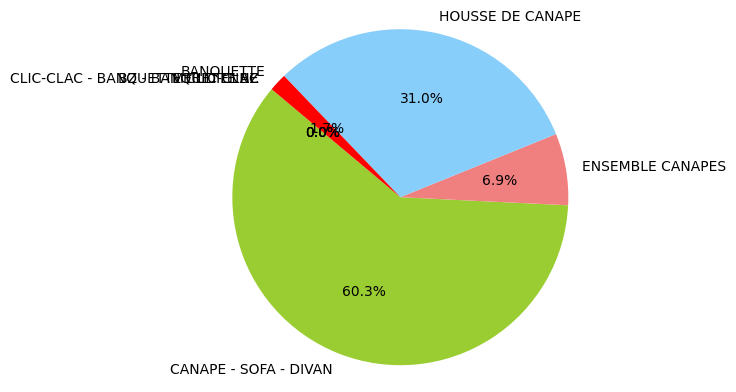

In [101]:
import matplotlib.pyplot as plt

major_categ_counts = {'CLIC-CLAC - BANQUETTE CLIC-CLAC': 0, 'CANAPE - SOFA - DIVAN': 0, 'ENSEMBLE CANAPES': 0, 'HOUSSE DE CANAPE': 0, 'BANQUETTE': 0, 'BZ - BANQUETTE BZ': 0, 'MERIDIENNE': 0}
for i, row in communities_df.iterrows():
    categ = row.category_counts
    major_categ_key = max(categ, key=categ.get)
    major_categ_counts[major_categ_key] += 1
    
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'black', 'brown']
plt.pie(major_categ_counts.values(), labels=major_categ_counts.keys(), colors=colors, autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.show()

In [87]:
communities_df.sort_values("community_size", ascending=False, inplace=True)
count = 0
for i, row in communities_df.iterrows():
    print("Index:", i)
    print("    ------TF_IDF_TOP_WORDS------")
    print("    ", row.tf_idf_top_words)
    print("\n    ------COUNT_VECTORIZER_TOP_WORDS------")
    print("    ", row.count_vectorizer_top_words)
    if creation == 2:
        print("\n    ------AVERAGE_DISTANCE------")
        print("    ", row.average_distance)
    print("\n    ------PRODUCTS_NAME_SAMPLE------")
    products_list = row.product_name_list[:25]
    for product in products_list:
        print("       ", product)
    #print("    \n\n------DOCUMENT------")
    #print(row.document[:1000])
    print("\n\n    ------CATEGORY_COUNTS------")
    print("    ", row.category_counts, end="\n\n-------------------------------------------------------------\n\n\n")
    count += 1
    if count == 15:
        break

Index: 2745
    ------TF_IDF_TOP_WORDS------
     housse

    ------COUNT_VECTORIZER_TOP_WORDS------
     canape | housse

    ------PRODUCTS_NAME_SAMPLE------
        housse de protection pour_canape 135x 80x 80cm
        housse de protection pour_canape 170x 90x 90cm
        housse fauteuil cabriolet,prochosen 2pieces housse de fauteuil tullsta cocktail extensible housse tub chair salon careau 2 f
        qiilu housse de canape extensible housses de canape housse de canape 1place extensible de couleur pure elegante pour_la
        housse de canape 1places avec_accoudo motif rouge
        3place housse de canape extensible avec_accoudoir avec_2taies 190 230cm
        housse de canape 1places avec_accoudoirs protecteur canape extensible 90 140cm motif vert
        1place housse de canape epaissie elastique super general des quatre saisons motif noir
        xjydncg housse de canape 3places 190 245cm super stretch blanc
        xjydncg 2place 145 185cm housse de canape extensible avec_2

In [98]:
row = communities_df.where(communities_df.average_distance == communities_df.average_distance.max()).dropna()
print("    ------TF_IDF_TOP_WORDS------")
print("    ", row.tf_idf_top_words)
print("\n    ------COUNT_VECTORIZER_TOP_WORDS------")
print("    ", row.count_vectorizer_top_words)
print("\n    ------AVERAGE_DISTANCE------")
print("    ", row.average_distance)
print("\n    ------PRODUCTS_NAME_SAMPLE------")
products_list = row.product_name_list[:10].item()
for product in products_list:
    print("       ", product)
#print("    \n\n------DOCUMENT------")
#print(row.document[:1000])
print("\n\n    ------CATEGORY_COUNTS------")
print("    ", row.category_counts, end="\n\n-------------------------------------------------------------\n\n\n")

    ------TF_IDF_TOP_WORDS------
     5    tole | asseyez | savourez | diner | delicieux ...
Name: tf_idf_top_words, dtype: object

    ------COUNT_VECTORIZER_TOP_WORDS------
     5    metal | diner | jardin | coupe | ensemble | ma...
Name: count_vectorizer_top_words, dtype: object

    ------AVERAGE_DISTANCE------
     5    0.994541
Name: average_distance, dtype: float64

    ------PRODUCTS_NAME_SAMPLE------
        zjchao mobilier a diner de jardin 3pcs maille metal anthracite
        zjchao mobilier a diner de jardin 5pcs maille metal anthracite
        zjchao mobilier a diner de jardin 3pcs maille metal anthracite
        zjchao mobilier a diner de jardin 5pcs maille metal anthracite
        zjchao mobilier a diner de jardin 5pcs maille metal anthracite
        zjchao mobilier a diner de jardin 3pcs maille metal anthracite
        zjchao mobilier a diner de jardin 5pcs maille metal anthracite
        zjchao mobilier a diner de jardin 3pcs maille metal anthracite
        zjchao mobi

In [89]:
rows = communities_df.where(communities_df.community_size <= 120).dropna()
for i, row in rows.iterrows():
    print("Index:", i)
    print("    ------TF_IDF_TOP_WORDS------")
    print("    ", row.tf_idf_top_words)
    print("\n    ------COUNT_VECTORIZER_TOP_WORDS------")
    print("    ", row.count_vectorizer_top_words)
    print("\n    ------AVERAGE_DISTANCE------")
    print("    ", row.average_distance)
    print("\n    ------PRODUCTS_NAME_SAMPLE------")
    products_list = row.product_name_list[:10]
    for product in products_list:
        print("       ", product)
    #print("    \n\n------DOCUMENT------")
    #print(row.document[:1000])
    print("\n\n    ------CATEGORY_COUNTS------")
    print("    ", row.category_counts, end="\n\n-------------------------------------------------------------\n\n\n")

Index: 133
    ------TF_IDF_TOP_WORDS------
     livin24 | memphis | 25places | denver | vegas | epure | pouvez | allonger | moins | ajouter

    ------COUNT_VECTORIZER_TOP_WORDS------
     canape | coussins

    ------AVERAGE_DISTANCE------
     0.8856835697768412

    ------PRODUCTS_NAME_SAMPLE------
        livin24 canape d angle industriel memphis eco cuir brun droit
        livin24 canape scandinave memphis 3places tissu chine anthracite melange
        livin24 canape d angle gauche en velours denver noir
        livin24 canape industriel 25places vegas eco cuir vert
        livin24 canape velours 25places denver noir
        livin24 canape scandinave 25places denver noir tissu chine
        livin24 canape en velours 25places vegas taupe
        livin24 canape 2places denver tissu chenille rose
        livin24 canape d angle industriel memphis eco cuir vert droit
        livin24 canape industriel d angle droit denver vert olive eco cuir


    ------CATEGORY_COUNTS------
     {'CAN